# **PRE PROCESSING SETPS**

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Spark version: 3.5.1

>> Please upload your HDFCBANK.csv when the file chooser appears...


Saving HDFCBANK.csv to HDFCBANK.csv
Using CSV: HDFCBANK.csv

Raw schema:
root
 |-- fiscal_year: string (nullable = true)
 |-- Loan Approvals/ Sanctions: string (nullable = true)
 |-- Loan Disbursements: string (nullable = true)
 |-- Housing Loan Outstanding (end Year): string (nullable = true)


Renamed columns: ['fiscal_year', 'loan_approvals_sanctions', 'loan_disbursements', 'housing_loan_outstanding_end_year']
+----+----------------+-----------------------------+-----------------------+--------------------------------------+---------+
|rows|null_fiscal_year|null_loan_approvals_sanctions|null_loan_disbursements|null_housing_loan_outstanding_end_year|null_year|
+----+----------------+-----------------------------+-----------------------+--------------------------------------+---------+
|1776|0               |0                            |0                      |0                                     |0        |
+----+----------------+-----------------------------+----------------------

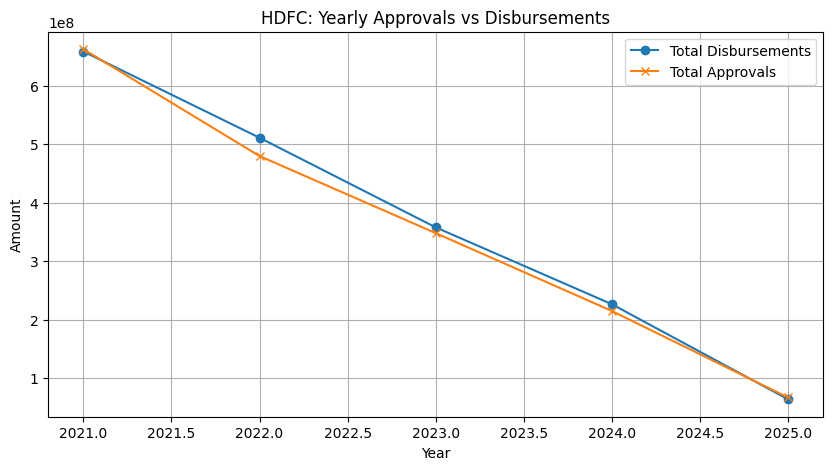

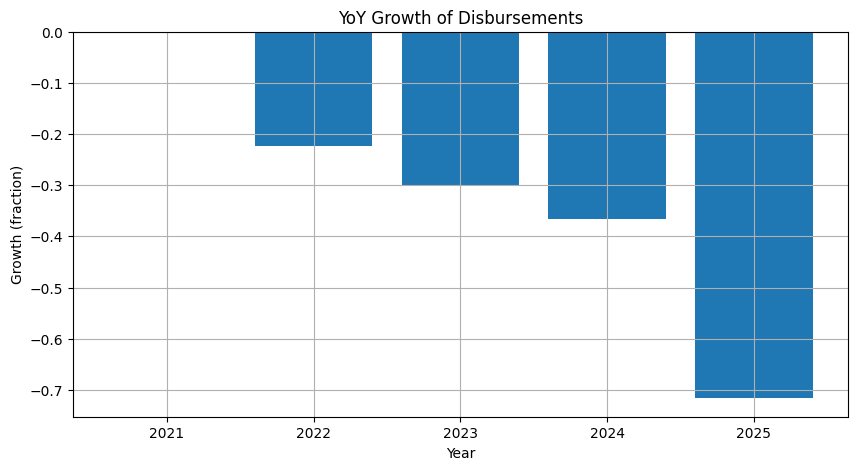

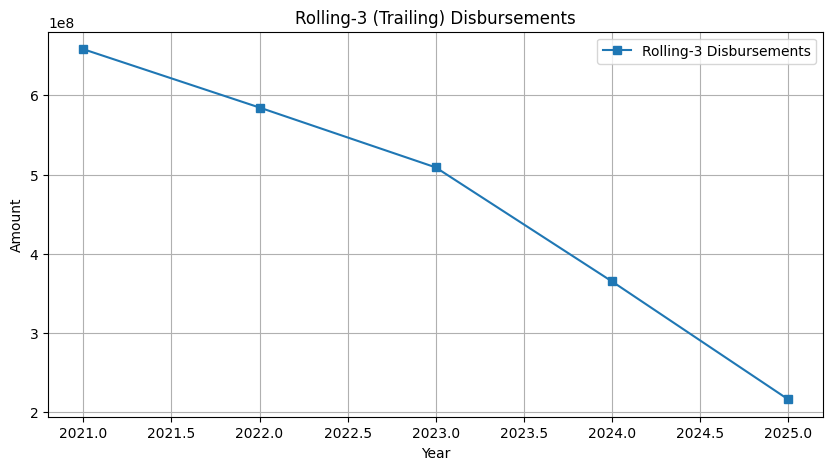


All done. Outputs saved to: /content/hdfc_outputs
Files:
 - anomalies_yoy.csv
 - model_predictions.csv
 - yearly_aggregations.csv
 - yearly_features.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# ============================
#
# ============================
# aggregated by year to see how approvals,
# disbursements, and outstanding balances changed.
# ----------------------------

# ---- 0. Colab setup (Java + Spark) ----
import sys, os, re, math, shutil, warnings
warnings.filterwarnings("ignore")

# Detect Colab
IN_COLAB = False
try:
    import google.colab  # type: ignore
    IN_COLAB = True
except Exception:
    IN_COLAB = False

if IN_COLAB:
    # Java + PySpark for Colab
    !apt-get -qq update
    !apt-get -qq install -y openjdk-11-jdk > /dev/null
    !pip -q install pyspark==3.5.1 findspark==2.0.1

# ---- 1. Imports ----
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import types as T
from pyspark.sql.window import Window

# ---- 2. Start Spark ----
spark = (
    SparkSession.builder
    .appName("HDFC-Housing-Loans-BigData-Pipeline")
    .config("spark.ui.showConsoleProgress", "false")
    .getOrCreate()
)
print("Spark version:", spark.version)

# ---- 3. Acquire the CSV ----
# Option A (default): Upload from your local machine when prompted.
csv_path = None
if IN_COLAB:
    from google.colab import files
    print("\n>> Please upload your HDFCBANK.csv when the file chooser appears...")
    uploaded = files.upload()
    # grab first uploaded file
    csv_path = list(uploaded.keys())[0] if uploaded else None

# Option B: If using Drive (uncomment and set path)
# from google.colab import drive
# drive.mount('/content/drive')
# csv_path = "/content/HDFCBANK.csv"

# Option C: If you already know the path in Colab VM (replace below)
# csv_path = "/content/HDFCBANK.csv"

# Safety check (falls back politely)
if csv_path is None:
    raise FileNotFoundError("No CSV provided. Please upload HDFCBANK.csv or set csv_path to its location.")

print("Using CSV:", csv_path)

# ---- 4. Read with Spark (robust parsing) ----
# Read raw to let us clean commas/strings explicitly
raw_df = (
    spark.read.format("csv")
    .option("header", True)
    .option("inferSchema", False)  # we'll cast manually
    .load(csv_path)
)

print("\nRaw schema:")
raw_df.printSchema()

# Normalize column names (safe snake_case)
def safe_col(c):
    c = c.strip()
    c = c.lower()
    c = re.sub(r"[^a-z0-9]+", "_", c)
    c = re.sub(r"_+", "_", c).strip("_")
    return c

old_to_new = {c: safe_col(c) for c in raw_df.columns}
df = raw_df
for old, new in old_to_new.items():
    df = df.withColumnRenamed(old, new)

print("\nRenamed columns:", df.columns)

# Expected cols (from your uploaded file preview)
# ['fiscal_year', 'loan_approvals_sanctions', 'loan_disbursements', 'housing_loan_outstanding_end_year']

# ---- 5. Clean numeric columns (remove commas, cast to double) ----
num_cols_guess = [c for c in df.columns if c != "fiscal_year"]
def to_double(col):
    return F.regexp_replace(F.col(col), r"[,\s]", "").cast(T.DoubleType())

for c in num_cols_guess:
    df = df.withColumn(c, to_double(c))

# ---- 6. Parse fiscal_year to extract a Year (int) ----
# Handles values like "2018-19", "FY 2019-20", "2020", etc.
extract_year_udf = F.udf(lambda s: int(re.search(r"(\d{4})", s).group(1)) if s and re.search(r"(\d{4})", s) else None, T.IntegerType())
df = df.withColumn("year", extract_year_udf(F.col("fiscal_year")))

# Optional: order index if there are multiple rows per fiscal_year (we'll just keep as-is)
df = df.filter(F.col("year").isNotNull())

# ---- 7. Basic Data Quality Checks ----
summary = df.select(
    F.count("*").alias("rows"),
    *[F.sum(F.when(F.col(c).isNull(), 1).otherwise(0)).alias(f"null_{c}") for c in df.columns]
)
summary.show(truncate=False)

# ---- 8. Aggregations by Year ----
agg = (
    df.groupBy("year")
      .agg(
          F.sum("loan_approvals_sanctions").alias("total_approvals"),
          F.sum("loan_disbursements").alias("total_disbursements"),
          F.avg("loan_disbursements").alias("avg_disbursements"),
          F.sum("housing_loan_outstanding_end_year").alias("sum_outstanding")
      )
      .orderBy("year")
)

print("\nAggregations by year:")
agg.show(20, truncate=False)

# ---- 9. Window features (YoY growth, rolling mean) ----
w_year = Window.orderBy("year")

feat = (
    agg
    .withColumn("lag_disbursements", F.lag("total_disbursements").over(w_year))
    .withColumn(
        "yoy_growth_disb",
        F.when(F.col("lag_disbursements").isNull(), F.lit(None).cast(T.DoubleType()))
         .otherwise((F.col("total_disbursements") - F.col("lag_disbursements")) / F.col("lag_disbursements"))
    )
    .withColumn("roll3_disb", F.avg("total_disbursements").over(w_year.rowsBetween(-2, 0)))
    .withColumn("approval_to_disb_ratio",
                F.when(F.col("total_disbursements") > 0, F.col("total_approvals")/F.col("total_disbursements"))
                 .otherwise(F.lit(None)))
)

print("\nFeatures with YoY growth & rolling mean:")
feat.show(20, truncate=False)

# ---- 10. CAGR (first to last year) for Disbursements ----
first_last = feat.select(F.first("year").alias("y0"),
                         F.last("year").alias("yN"),
                         F.first("total_disbursements").alias("D0"),
                         F.last("total_disbursements").alias("DN")).collect()[0]
y0, yN, D0, DN = first_last.y0, first_last.yN, first_last.D0, first_last.DN
years_span = max(1, (yN - y0))
CAGR = None
if D0 and D0 > 0 and DN and DN > 0:
    CAGR = (DN / D0) ** (1/years_span) - 1
print(f"\nCAGR (Disbursements) from {y0} to {yN}: {CAGR:.4f}" if CAGR is not None else "\nCAGR could not be computed.")

# ---- 11. Correlations ----
corr_approvals_disb = feat.select(F.corr("total_approvals", "total_disbursements").alias("corr")).collect()[0].corr
print(f"Correlation (Total Approvals vs Total Disbursements): {corr_approvals_disb:.4f}")

# ---- 12. Anomaly detection via z-score on YoY growth ----
stats = feat.select(
    F.mean("yoy_growth_disb").alias("mu"),
    F.stddev("yoy_growth_disb").alias("sigma")
).collect()[0]
mu, sigma = stats.mu, stats.sigma if stats.sigma else 0.0
feat = feat.withColumn("z_yoy", (F.col("yoy_growth_disb") - F.lit(mu)) / F.lit(sigma if sigma and sigma != 0 else 1.0))
anomalies = feat.filter(F.abs(F.col("z_yoy")) > 1.0).orderBy(F.desc(F.abs(F.col("z_yoy"))))
print("\nAnomalies (|z| > 2) by YoY growth of Disbursements:")
anomalies.show(truncate=False)

# ---- 13. Prepare data for modeling (Spark ML) ----
# Predict yearly total_disbursements from:
#   total_approvals, roll3_disb (lagged), previous year's disbursements, and ratio.
model_df = (
    feat
    .withColumn("lag1", F.lag("total_disbursements").over(w_year))
    .withColumn("roll3_disb_filled", F.when(F.col("roll3_disb").isNull(), F.col("total_disbursements")).otherwise(F.col("roll3_disb")))
    .dropna(subset=["lag1", "total_approvals", "total_disbursements"])
)

from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline

feature_cols = ["total_approvals", "lag1", "roll3_disb_filled", "approval_to_disb_ratio"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_raw")
scaler = StandardScaler(inputCol="features_raw", outputCol="features", withMean=True, withStd=True)
rf = RandomForestRegressor(featuresCol="features", labelCol="total_disbursements", maxDepth=5, numTrees=200, seed=42)

pipeline = Pipeline(stages=[assembler, scaler, rf])
train_df, test_df = model_df.randomSplit([0.75, 0.25], seed=123)

model = pipeline.fit(train_df)
pred = model.transform(test_df)

from pyspark.ml.evaluation import RegressionEvaluator
rmse = RegressionEvaluator(labelCol="total_disbursements", predictionCol="prediction", metricName="rmse").evaluate(pred)
r2   = RegressionEvaluator(labelCol="total_disbursements", predictionCol="prediction", metricName="r2").evaluate(pred)
print(f"\nModel performance — RMSE: {rmse:.2f}, R^2: {r2:.3f}")

# ---- 14. Visualizations (collect to pandas for plotting) ----
pdf_feat = feat.select("year", "total_approvals", "total_disbursements", "yoy_growth_disb", "roll3_disb").orderBy("year").toPandas()

plt.figure(figsize=(10,5))
plt.plot(pdf_feat["year"], pdf_feat["total_disbursements"], marker="o", label="Total Disbursements")
plt.plot(pdf_feat["year"], pdf_feat["total_approvals"], marker="x", label="Total Approvals")
plt.title("HDFC: Yearly Approvals vs Disbursements")
plt.xlabel("Year"); plt.ylabel("Amount"); plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(10,5))
plt.bar(pdf_feat["year"], pdf_feat["yoy_growth_disb"].fillna(0))
plt.title("YoY Growth of Disbursements")
plt.xlabel("Year"); plt.ylabel("Growth (fraction)"); plt.grid(True); plt.show()

plt.figure(figsize=(10,5))
plt.plot(pdf_feat["year"], pdf_feat["roll3_disb"], marker="s", label="Rolling-3 Disbursements")
plt.title("Rolling-3 (Trailing) Disbursements")
plt.xlabel("Year"); plt.ylabel("Amount"); plt.legend(); plt.grid(True); plt.show()

# ---- 15. Save artifacts (CSVs) ----
out_dir = "/content/hdfc_outputs" if IN_COLAB else "./hdfc_outputs"
os.makedirs(out_dir, exist_ok=True)

agg.toPandas().to_csv(os.path.join(out_dir, "yearly_aggregations.csv"), index=False)
feat.toPandas().to_csv(os.path.join(out_dir, "yearly_features.csv"), index=False)
anomalies.toPandas().to_csv(os.path.join(out_dir, "anomalies_yoy.csv"), index=False)
pred.select("year", "total_disbursements", "prediction").toPandas().to_csv(os.path.join(out_dir, "model_predictions.csv"), index=False)

print(f"\nAll done. Outputs saved to: {out_dir}")
print("Files:")
for f in sorted(os.listdir(out_dir)):
    print(" -", f)

# ---- 16. (Optional) Download zips when in Colab ----
if IN_COLAB:
    shutil.make_archive("/content/hdfc_outputs_zip", "zip", out_dir)
    from google.colab import files
    files.download("/content/hdfc_outputs_zip.zip")


Total Approvals & Disbursements → yearly sum of how much HDFC sanctioned vs actually gave.

Avg Disbursements → average loan size.

Sum Outstanding → total loan balance remaining at year-end.
n 2021, HDFC sanctioned ₹662 crore, disbursed ₹658 crore, with ~₹641 crore outstanding.
Over time (2021 → 2025), both approvals and disbursements are falling sharply.

lag_disbursements → previous year’s disbursement (for comparison).

yoy_growth_disb → year-on-year % change in disbursement.

Negative after 2022 → disbursements are shrinking every year.

roll3_disb → 3-year rolling average to smooth out fluctuations (shows long-term decline).

approval_to_disb_ratio → efficiency ratio: how much of approvals get disbursed.

Close to 1 → HDFC converts approvals into disbursements very efficiently.
In 2025, disbursements were only ~29% of 2024 level (YoY = -71.6%). But approvals/disbursement ratio = 1.04 (almost one-to-one).

In [ ]:
import pandas as pd

# Load your CSV
file_path = "/content/HDFCBANK.csv" # Load the original CSV
df = pd.read_csv(file_path)

# Melt loan-related columns into category-amount pairs, using fiscal_year as id
melted = df.melt(id_vars=['fiscal_year'],
                 value_vars=['Loan Approvals/ Sanctions', 'Loan Disbursements', 'Housing Loan Outstanding (end Year)'],
                 var_name='category', value_name='amount')

# Save new file for Spark
new_path = "/content/HDFC_restructured.csv"
melted.to_csv(new_path, index=False)

display(melted.head(10))

,fiscal_year,category,amount
0,4/22/2021 21:21,Loan Approvals/ Sanctions,1844950
1,5/21/2021 16:49,Loan Approvals/ Sanctions,555167
2,9/17/2021 3:57,Loan Approvals/ Sanctions,921905
3,7/23/2021 19:28,Loan Approvals/ Sanctions,863232
4,12/20/2021 9:12,Loan Approvals/ Sanctions,1906174
5,9/19/2021 21:46,Loan Approvals/ Sanctions,1982672
6,5/8/2021 2:04,Loan Approvals/ Sanctions,1943154
7,7/30/2021 22:26,Loan Approvals/ Sanctions,1198724
8,4/30/2021 19:26,Loan Approvals/ Sanctions,451165
9,2/7/2021 0:13,Loan Approvals/ Sanctions,403551


In [ ]:
for c in df.columns:
    null_count = df[c].isnull().sum()
    empty_str_count = (df[c] == '').sum()
    invalid_text_count = df[c].astype(str).str.lower().str.match(r"^(na|nan|null|-)$").sum()

    print(f"Column '{c}':")
    print(f"  Nulls: {null_count}")
    print(f"  Empty Strings: {empty_str_count}")
    print(f"  Invalid Text ('na', 'nan', 'null', '-'): {invalid_text_count}")
    print("-" * 20)

Column 'fiscal_year':
  Nulls: 0
  Empty Strings: 0
  Invalid Text ('na', 'nan', 'null', '-'): 0
--------------------
Column 'Loan Approvals/ Sanctions':
  Nulls: 0
  Empty Strings: 0
  Invalid Text ('na', 'nan', 'null', '-'): 0
--------------------
Column 'Loan Disbursements':
  Nulls: 0
  Empty Strings: 0
  Invalid Text ('na', 'nan', 'null', '-'): 0
--------------------
Column 'Housing Loan Outstanding (end Year)':
  Nulls: 0
  Empty Strings: 0
  Invalid Text ('na', 'nan', 'null', '-'): 0
--------------------
